In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from gen_data import gen_data_complex
from proximal import proximal_direct_effect, ProximalDE

# Running a Single Experiment

In [3]:
def exp_res(it, n, pw, pz, px, a, b, c, d, e, f, g, *,
            n_splits=5, semi=False, multitask=False, n_jobs=-1):
    np.random.seed(it)
    # M is unobserved so we omit it from the return variables
    W, D, _, Z, X, Y = gen_data_complex(n, pw, pz, px, a, b, c, d, e, f, g)
    return proximal_direct_effect(W, D, Z, X, Y,
                                  cv=n_splits, semi=semi,
                                  multitask=multitask, n_jobs=n_jobs,
                                  random_state=it)

In [4]:
a = .3
b = .6
c = .5 # this is the direct effect we want to estimate
d = .7
e = .5 # if the product of e*f is small, then we have a weak instrument
f = .5 # if the product of e*f is small, then we have a weak instrument
g = .9

In [5]:
n = 10000
pw = 10
pz, px = 5, 5
n_splits = 3
point, stderr, r2D, r2Z, r2X, r2Y, jac, point_pre, stderr_pre = exp_res(3, n, pw, pz, px, a, b, c, d, e, f, g,
                                                 n_splits=n_splits, semi=True)
pd.DataFrame({'point': point, 'se': stderr, 'r2D': r2D, 'r2Z': r2Z, 'r2X': r2X, 'r2Y': r2Y, 'Jacobian': jac,
              'point_pre': point_pre, 'se_pre': stderr_pre}, index=[0])

Residualizing D...
Residualizing Z...
Residualizing X...
Residualizing Y...


,point,se,r2D,r2Z,r2X,r2Y,Jacobian,point_pre,se_pre
0,0.526032,0.036299,0.365023,0.590544,0.539387,0.614712,0.155583,0.507735,0.035534


### Using the Estimator Class

In [6]:
np.random.seed(3)
W, D, _, Z, X, Y = gen_data_complex(n, pw, pz, px, a, b, c, d, e, f, g)
est = ProximalDE(cv=3, semi=True, multitask=False, n_jobs=-1, random_state=3)
est.fit(W, D, Z, X, Y)

Residualizing D...
Residualizing Z...
Residualizing X...
Residualizing Y...


ProximalDE(cv=3, random_state=3)

In [8]:
est.summary()

,point,stderr,zstat,pvalue,ci_lower,ci_upper
param,0.526,0.036,14.492,0.0,0.455,0.597


### Subsample-Based Inference

In [9]:
inf = est.bootstrap_inference(stage=3, n_subsamples=1000, fraction=0.5, replace=False, verbose=3)
inf.summary()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


,point,stderr,zstat,pvalue,ci_lower,ci_upper
param,0.526,0.038,13.805,0.0,0.454,0.604


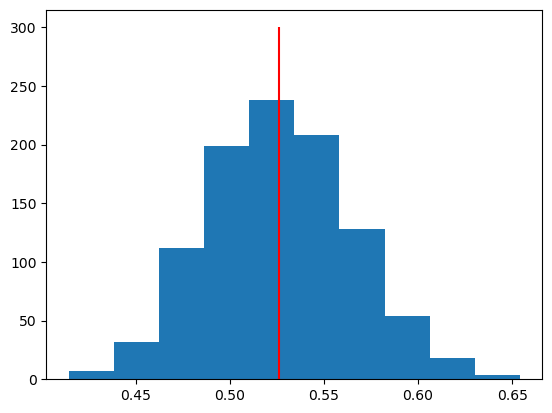

In [10]:
plt.hist(inf.point_dist)
plt.vlines([inf.point], 0, 300, color='r')
plt.show()

In [11]:
inf = est.bootstrap_inference(stage=2, n_subsamples=1000, fraction=0.5, replace=False, verbose=3)
inf.summary()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


,point,stderr,zstat,pvalue,ci_lower,ci_upper
param,0.526,0.053,9.856,0.0,0.423,0.628


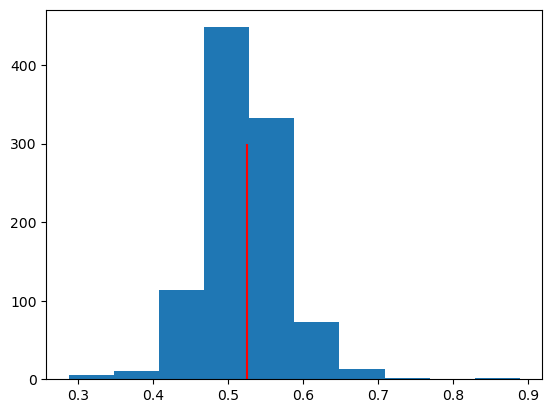

In [12]:
plt.hist(inf.point_dist)
plt.vlines([inf.point], 0, 300, color='r')
plt.show()

In [17]:
inf = est.bootstrap_inference(stage=1, n_subsamples=1000, fraction=0.5, replace=False, verbose=3)
inf.summary()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.9min finished


,point,stderr,zstat,pvalue,ci_lower,ci_upper
param,0.526,0.053,9.904,0.0,0.417,0.625


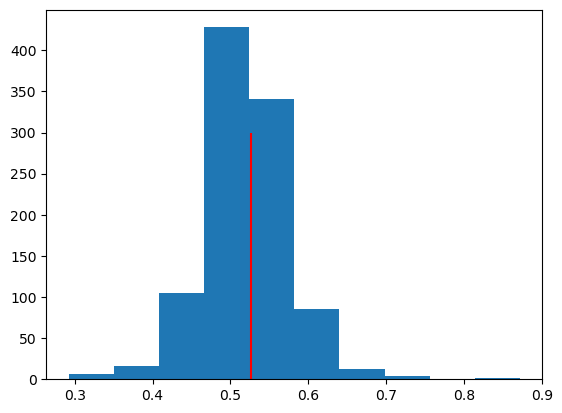

In [19]:
plt.hist(inf.point_dist)
plt.vlines([inf.point], 0, 300, color='r')
plt.show()

In [21]:
inf.summary(pivot=True)

,point,stderr,zstat,pvalue,ci_lower,ci_upper
param,0.526,0.053,9.904,0.0,0.427,0.635


# Coverage Experiment

In [14]:
n = 10000
pw = 10
pz, px = 30, 30
n_splits = 3

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp_res)(i, n, pw, pz, px, a, b, c, d, e, f, g,
                                                           n_splits=n_splits, semi=True, n_jobs=1)
                                          for i in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 24.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.4min finished


In [15]:
points_base, stderrs_base, rmseD, rmseZ, rmseX, rmseY, jac, points_alt, stderrs_alt = zip(*results)
points_base = np.array(points_base)
stderrs_base = np.array(stderrs_base)
points_alt = np.array(points_alt)
stderrs_alt = np.array(stderrs_alt)

for points, stderrs in [(points_base, stderrs_base), (points_alt, stderrs_alt)]:
    coverage = np.mean((points + 1.96 * stderrs >= c) & (points - 1.96 * stderrs <= c))
    rmse = np.sqrt(np.mean((points - c)**2))
    bias = np.abs(np.mean(points) - c)
    std = np.std(points)
    mean_stderr = np.mean(stderrs)
    mean_length = np.mean(2 * 1.96 * stderrs)
    median_length = np.median(2 * 1.96 * stderrs)
    print(f"Coverage: {coverage:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"Bias: {bias:.3f}")
    print(f"Std: {std:.3f}")
    print(f"Mean CI length: {mean_length:.3f}")
    print(f"Median CI length: {mean_length:.3f}")
    print(f"Mean Estimated Stderr: {mean_stderr:.3f}")
    print(f"Nuisance R^2 (D, Z, X, Y): {np.mean(rmseD):.3f}, {np.mean(rmseZ):.3f}, {np.mean(rmseX):.3f}, {np.mean(rmseY):.3f}")

Coverage: 0.950
RMSE: 0.034
Bias: 0.009
Std: 0.033
Mean CI length: 0.143
Median CI length: 0.143
Mean Estimated Stderr: 0.037
Nuisance R^2 (D, Z, X, Y): 0.367, 0.594, 0.544, 0.618
Coverage: 0.480
RMSE: 0.071
Bias: 0.061
Std: 0.036
Mean CI length: 0.131
Median CI length: 0.131
Mean Estimated Stderr: 0.033
Nuisance R^2 (D, Z, X, Y): 0.367, 0.594, 0.544, 0.618


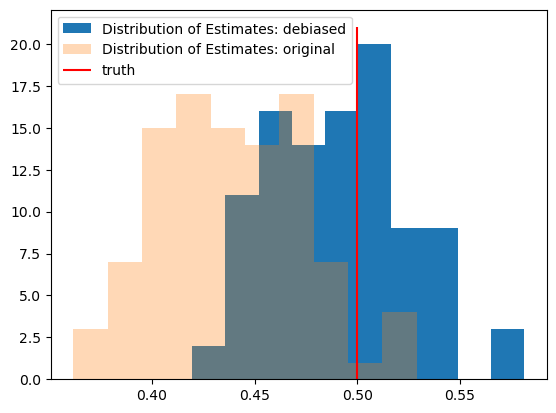

In [16]:
plt.hist(points_base, label='Distribution of Estimates: debiased')
plt.hist(points_alt, label='Distribution of Estimates: original', alpha=.3)
plt.vlines([c], 0, plt.ylim()[1], color='red', label='truth')
plt.legend()
plt.show()